# Data Augmentation - Cifar 
## Step 0: Import libraries

In [12]:
###############################################
# Import Machine Learning Assets
###############################################
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mlflow


###############################################
# Import Miscellaneous Assets
###############################################
# import joblib # To save sklearn models
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sn
from scipy.stats import anderson # Anderson-Darling Test
import sys
import matplotlib.pyplot as plt

# parent_folder = str(Path(os.getcwd()).parent)
# sys.path.insert(1, parent_folder)

from src.visualization.visualize import visualize_data
from src.models.train_model import create_model

## Step 1: Without data augmentation

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

print(x_train.shape) 
print(y_train.shape) 
print(x_test.shape) 
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


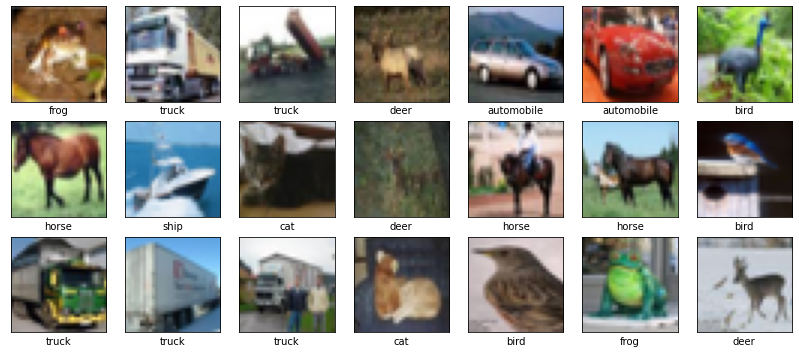

In [14]:
visualize_data(x_train, y_train, class_names)

In [15]:
batch_size = 32
epochs = 10

m_no_aug = create_model()
m_no_aug.summary()

history_no_aug = m_no_aug.fit(
    x_train, y_train,
    epochs=epochs, batch_size=batch_size,
    validation_data=(x_test, y_test))

loss_no_aug, acc_no_aug = m_no_aug.evaluate(x_test,  y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [16]:
# serialize model to JSON
model_json = m_no_aug.to_json()
with open("../models/m_no_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m_no_aug.save_weights("../models/m_no_aug.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
print(acc_no_aug)

0.7233


## Step 2: With data augmentation

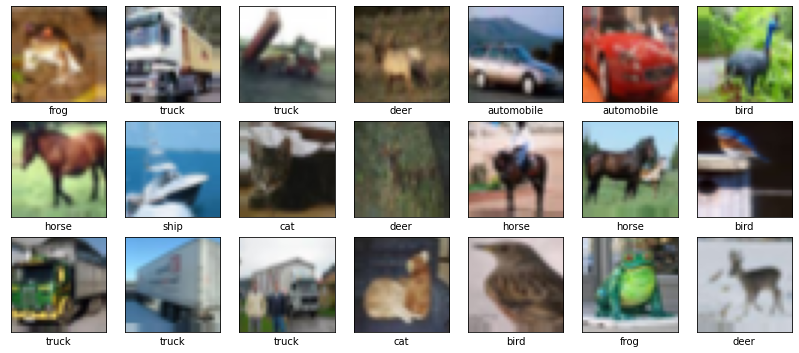

In [18]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [19]:
m_aug = create_model()
datagen.fit(x_train)

history_aug = m_aug.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test))
loss_aug, acc_aug = m_aug.evaluate(x_test,  y_test)

  ...
    to  
  ['...']
Train for 1563 steps, validate on 10000 samples
Epoch 1/10
1563/1563 [==============================] - 249s 160ms/step - loss: 1.4882 - accuracy: 0.4595 - val_loss: 1.1324 - val_accuracy: 0.5919
Epoch 2/10
1563/1563 [==============================] - 240s 154ms/step - loss: 1.1109 - accuracy: 0.6049 - val_loss: 0.9400 - val_accuracy: 0.6680
Epoch 3/10
1563/1563 [==============================] - 242s 155ms/step - loss: 0.9679 - accuracy: 0.6573 - val_loss: 0.8620 - val_accuracy: 0.7001
Epoch 4/10
1563/1563 [==============================] - 251s 161ms/step - loss: 0.8786 - accuracy: 0.6918 - val_loss: 0.8200 - val_accuracy: 0.7150
Epoch 5/10
1563/1563 [==============================] - 264s 169ms/step - loss: 0.8138 - accuracy: 0.7165 - val_loss: 0.7899 - val_accuracy: 0.7323
Epoch 6/10
1563/1563 [==============================] - 1097s 702ms/step - loss: 0.7718 - accuracy: 0.7314 - val_loss: 0.7644 - val_accuracy: 0.7369
Epoch 7/10
1563/1563 [================

In [25]:
# serialize model to JSON
model_json = m_aug.to_json()
with open("../models/m_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m_aug.save_weights("../models/m_aug.h5")
print("Saved model to disk")

Saved model to disk


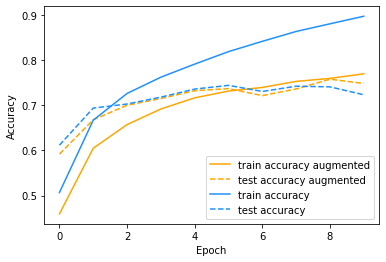

In [21]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(history_no_aug.history['accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(history_no_aug.history['val_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

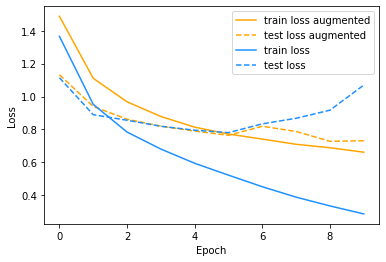

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_aug.history['loss'],
         label='train loss augmented',
         c='orange', ls='-')
plt.plot(history_aug.history['val_loss'],
         label='test loss augmented',
         c='orange',ls='--')

plt.plot(history_no_aug.history['loss'],
         label='train loss',
         c='dodgerblue', ls='-')
plt.plot(history_no_aug.history['val_loss'],
         label='test loss',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()